In [1]:
from typing import Type, Optional, Union, Tuple

import numpy as np
import pandas as pd
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from skopt import gp_minimize

import matplotlib.pyplot as plt 
plt.rcParams['figure.facecolor'] = "white"

from reservoir import reservoir as res
from data import data
from error import error

In [2]:
# define constants 
DEL_T = 0.01        # time step size
LAMBDA = 0.9056     # lorenz lyapunov exponent
STEPS = 30000       # total steps
WASHOUT = 10000     # washout 
n = STEPS - WASHOUT # remaining number of time steps kept
SEED = 42
state = np.random.RandomState(SEED)

In [3]:
# reservoir parameters
hyperparams = {
    'GAMMA': 7.7,
    'SIGMA': 0.81,
    'RHO_IN': 0.37,
    'K': 3,
    'RHO_R': 0.41
}

# hyperparameter ranges
GAMMA_RANGE = np.linspace(7, 11, 10)
SIGMA_RANGE = np.linspace(0.1, 1.0, 10)
RHO_IN_RANGE = np.linspace(0.3, 1.5, 10)
K_RANGE = range(1, 6)
RHO_R_RANGE = np.linspace(0.3, 1.5, 10)

# number of reservoir nodes
N = 100
# dimension of input signal
d = 3
# Tikohonov regularisation constant
ALPHA = 0.001

In [4]:
# # generate some data
# training_data = data.generate_lorenz_63(
#     initial_state=state.choice(np.linspace(-5, 5), 3),
#     del_t=DEL_T,
#     steps=STEPS,
#     washout=WASHOUT
# )
# forecast_data = data.generate_lorenz_63(
#     initial_state=state.choice(np.linspace(-5, 5), 3),
#     del_t=DEL_T,
#     steps=STEPS,
#     washout=WASHOUT
# )
lorenz = data.generate_lorenz_63(
        initial_state=state.choice(np.linspace(-5, 5), 3),
        del_t=DEL_T,
        steps=STEPS,
        washout=WASHOUT
    )
training_data = lorenz[: lorenz.shape[0] // 2]
forecast_data = lorenz[lorenz.shape[0] // 2:]

In [5]:
training_data.shape

(10000, 3)

In [6]:
# construct reservoir internals
W_in = res.generate_W_in(hyperparams=hyperparams, shape=(N, d), state=state)
W_r = res.generate_W_r(hyperparams=hyperparams, shape=(N, N), state=state)

unmodified_training_res = res.generate_training_reservoir(
    data=training_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    delta_t=DEL_T,
    adjust_for_symmetry=False
)

# form training reservoir
training_res = res.generate_training_reservoir(
    data=training_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    delta_t=DEL_T,
    adjust_for_symmetry=True
)

# train W_out
W_out = res.generate_W_out(
    data=training_data,
    res=training_res,
    alpha=ALPHA
)

In [7]:
training_preds = res.readout_network(training_res, W_out)

In [8]:
print(error.RMSE(training_preds, training_data))
print(error.griffith_epsilon_1(training_preds, training_data, delta_t=DEL_T, LAMBDA=LAMBDA))

[0.00076054 0.00255149 0.00153621]
4.8333040037280846


In [9]:
# construct forecast reservoir
forecast_res = res.generate_forecast_reservoir(
    # r_0 = np.dot(W_in, forecast_data[0]),
    r_0 = unmodified_training_res[-1],
    data=forecast_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    W_out=W_out,
    delta_t=DEL_T,
    adjust_for_symmetry=True
)

# make forecasts
preds = res.readout_network(res=forecast_res, W_out=W_out)

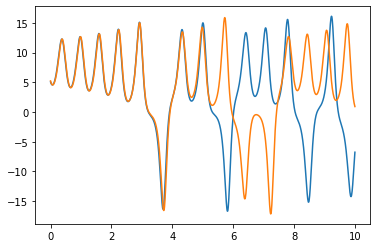

In [10]:
end = data.lyapunov_to_steps(10, LAMBDA, DEL_T)
x_range = LAMBDA * DEL_T * np.array(range(end))
plt.plot(x_range, forecast_data[:end, 0])
plt.plot(x_range, preds[:end, 0])

In [11]:
print(error.RMSE(forecast_data, preds))
print(np.linalg.norm(error.RMSE(forecast_data, preds)))
print(error.griffith_epsilon_1(forecast_data, preds, DEL_T, LAMBDA))

[0.7992173  0.9038913  0.83721026]
1.4685669150433402
3.6000919065086525


Write a function wrapper to do a simulation.

In [12]:
def find_start_and_end(range):
    return range[0], range[-1]

def generate_search_space(gamma_range=GAMMA_RANGE, sigma_range=SIGMA_RANGE, 
                          rho_in_range=RHO_IN_RANGE, k_range=K_RANGE, 
                          rho_r_range=RHO_R_RANGE) -> list:
    gamma_start, gamma_end = find_start_and_end(gamma_range)
    sigma_start, sigma_end = find_start_and_end(sigma_range)
    rho_in_start, rho_in_end = find_start_and_end(rho_in_range)
    k_start, k_end = find_start_and_end(k_range)
    rho_r_start, rho_r_end = find_start_and_end(rho_r_range)

    return [
        hp.uniform('gamma', gamma_start, gamma_end),
        hp.uniform('sigma', sigma_start, sigma_end),
        hp.uniform('rho_in', rho_in_start, rho_in_end),
        hp.choice('k', options=list(range(k_start, k_end + 1))),
        hp.uniform('rho_r', rho_r_start, rho_r_end),
    ]

In [13]:
# lorenz = data.generate_lorenz_63(
#         initial_state=state.choice(np.linspace(-5, 5), 3),
#         del_t=DEL_T,
#         steps=STEPS,
#         washout=WASHOUT
#     )
# training_data = lorenz[: lorenz.shape[0] // 2]
# forecast_data = lorenz[lorenz.shape[0] // 2:]

def objective(hyperparams: list) -> float:
    hyperparams = {
        'GAMMA': hyperparams[0],
        'SIGMA': hyperparams[1],
        'RHO_IN': hyperparams[2],
        'K': hyperparams[3],
        'RHO_R': hyperparams[4]
    }
    
    W_r = res.generate_W_r(hyperparams, (N, N), state)
    W_in = res.generate_W_in(hyperparams, (N, d), state)
    
    training_res = res.generate_training_reservoir(
        data = training_data,
        hyperparams = hyperparams,
        W_r = W_r,
        W_in = W_in,
        delta_t = DEL_T
    )
    unmodified_training_res = res.generate_training_reservoir(
        data = training_data,
        hyperparams = hyperparams,
        W_r = W_r,
        W_in = W_in,
        delta_t = DEL_T,
        adjust_for_symmetry=False
    )
    
    W_out = res.generate_W_out(data=training_data, res=training_res, alpha=ALPHA)
    forecast_res = res.generate_forecast_reservoir(
        r_0 = np.dot(W_in, forecast_data[0]),
        data = forecast_data,
        hyperparams=hyperparams,
        W_r = W_r,
        W_in = W_in,
        W_out = W_out,
        delta_t = DEL_T
    )

    preds = res.readout_network(res=forecast_res, W_out=W_out)

    # return max(error.RMSE(forecast_data, preds))
    return np.linalg.norm(error.RMSE(forecast_data, preds))
    # return error.griffith_epsilon_1(forecast_data, preds, delta_t=DEL_T, LAMBDA=LAMBDA)

In [14]:
hyperparams = {
    'GAMMA': 7.7,
    'SIGMA': 0.81,
    'RHO_IN': 0.37,
    'K': 3,
    'RHO_R': 0.41
}

In [15]:
# hyperparameter ranges
GAMMA_RANGE = np.linspace(7, 11, 10)
SIGMA_RANGE = np.linspace(0.1, 1.0, 10)
RHO_IN_RANGE = np.linspace(0.3, 1.5, 10)
K_RANGE = range(1, 6)
RHO_R_RANGE = np.linspace(0.3, 1.5, 10)
best = gp_minimize(
    func=objective,
    dimensions=[
        find_start_and_end(GAMMA_RANGE),
        find_start_and_end(SIGMA_RANGE),
        find_start_and_end(RHO_IN_RANGE),
        [1, 2, 3, 4, 5],
        find_start_and_end(RHO_R_RANGE)
    ],
    x0=[7.7, 0.81, 0.37, 3, 0.41],
    n_calls=20
)

KeyboardInterrupt: 

In [ ]:
print(best)

          fun: 21.047461400045744
    func_vals: array([  21.44077228,  111.2717574 ,   76.89583904,  152.16378585,
         74.55873599,  425.33159968, 1172.11692229,   21.69673061,
        202.36286147,   44.95456549,   21.09404155,   30.75657792,
         25.96262045,   21.0474614 ,   21.98370132,   21.60780736,
         21.80048875,   21.88783612,   21.07495633,   34.98593299])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1126895089), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1126895089), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(n

In [ ]:
best = fmin(
    fn=objective,
    space=generate_search_space(),
    algo=tpe.suggest,
    max_evals=100
)
print(best)

100%|██████████| 100/100 [02:26<00:00,  1.46s/trial, best loss: 16.494471923262125]
{'gamma': 10.619884123164502, 'k': 0, 'rho_in': 0.4236997191057481, 'rho_r': 1.1749933460662627, 'sigma': 0.26749509984338243}


In [ ]:
# define constants 
DEL_T = 0.01        # time step size
LAMBDA = 0.9056     # lorenz lyapunov exponent
STEPS = 30000       # total steps
WASHOUT = 10000     # washout 
n = STEPS - WASHOUT # remaining number of time steps kept
N = 100
d = 3
ALPHA = 0.001

GAMMA_RANGE = np.linspace(7, 11)
SIGMA_RANGE = np.linspace(0.1, 1.0)
RHO_IN_RANGE = np.linspace(0.2, 1)
K_RANGE = range(1, 6)
RHO_R_RANGE = np.linspace(0.3, 1.5)

def run_sim(search_space: list, state: np.random.RandomState, N: int = N, d: int = d, 
            alpha: float = ALPHA, show_progressbar: bool = True, 
            adjust_for_symmetry: bool = True) -> Tuple[dict, Trials]:
    # set state
    state = np.random.RandomState(SEED)

    # generate some data
    # training_data = data.generate_lorenz_63(
    #     initial_state=state.choice(np.linspace(-5, 5), 3),
    #     del_t=DEL_T,
    #     steps=STEPS,
    #     washout=WASHOUT
    # )
    # forecast_data = data.generate_lorenz_63(
    #     initial_state=state.choice(np.linspace(-5, 5), 3),
    #     del_t=DEL_T,
    #     steps=STEPS,
    #     washout=WASHOUT
    # )
    lorenz = data.generate_lorenz_63(
        initial_state=state.choice(np.linspace(-5, 5), 3),
        del_t=DEL_T,
        steps=STEPS,
        washout=WASHOUT
    )
    training_data = lorenz[: lorenz.shape[0] // 2]
    forecast_data = lorenz[lorenz.shape[0] // 2:]
    # uses 'constants' that are passed in
    def objective(hyperparams: list) -> float:
        # parse hyperparams list
        hyperparams = {
            'GAMMA': hyperparams[0],
            'SIGMA': hyperparams[1],
            'RHO_IN': hyperparams[2],
            'K': hyperparams[3],
            'RHO_R': hyperparams[4]
        }

        # construct reservoir internals
        W_in = res.generate_W_in(hyperparams=hyperparams, shape=(N, d), state=state)
        W_r = res.generate_W_r(hyperparams=hyperparams, shape=(N, N), state=state)

        # form training reservoir
        training_res = res.generate_training_reservoir(
            data=training_data,
            hyperparams=hyperparams,
            W_r=W_r,
            W_in=W_in,
            delta_t=DEL_T,
            adjust_for_symmetry=adjust_for_symmetry
        )

        # train W_out
        W_out = res.generate_W_out(
            data=training_data,
            res=training_res,
            alpha=alpha
        )

        # construct forecast reservoir
        forecast_res = res.generate_forecast_reservoir(
            r_0 = training_res[-1],
            data=forecast_data,
            hyperparams=hyperparams,
            W_r=W_r,
            W_in=W_in,
            W_out=W_out,
            delta_t=DEL_T,
            adjust_for_symmetry=adjust_for_symmetry
        )

        # make forecasts
        preds = res.readout_network(res=forecast_res, W_out=W_out)

        # compute loss
        return {
            'loss': np.linalg.norm(error.RMSE(forecast_data, preds)),
            'status': STATUS_OK,
            'W_r': {'type': np.ndarray, 'value': W_r},
            'W_in': {'type': np.ndarray, 'value': W_in},
            'W_out': {'type': np.ndarray, 'value': W_out},
            'training_res': {'type': np.ndarray, 'value': training_res},
            'forecast_res': {'type': np.ndarray, 'value': forecast_res},
            'preds': {'type': np.ndarray, 'value': preds},
        }

    trials = Trials()
    best = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=100,
        show_progressbar=show_progressbar,
        trials=trials
    )

    return best, trials, training_data, forecast_data

In [ ]:
search_space = generate_search_space()
best, trials, training_data, forecast_data = run_sim(
    search_space=search_space,
    state=state
)

100%|██████████| 100/100 [02:14<00:00,  1.35s/trial, best loss: 15.675120813303156]


In [ ]:
print(best)

{'gamma': 9.887674323963132, 'k': 3, 'rho_in': 1.2161426023597453, 'rho_r': 0.8762220140984149, 'sigma': 0.6974335412943475}


In [ ]:
def plot_param_vs_loss(trials, param):
    trial_params = [trials.trials[i]['misc']['vals'] for i in range(len(trials.losses()))]
    losses = trials.losses()

    params = [trial_params[i][param][0] for i in range(len(trials.losses()))]

    plt.title("Loss as a function of {}".format(param))
    plt.scatter(params, losses)
    plt.xlabel("{}".format(param))
    plt.ylabel("Loss")

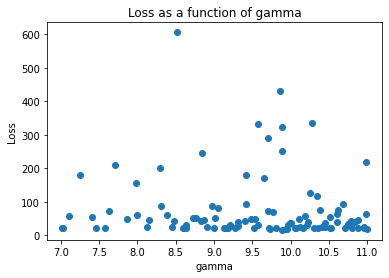

In [ ]:
plot_param_vs_loss(trials, "gamma")

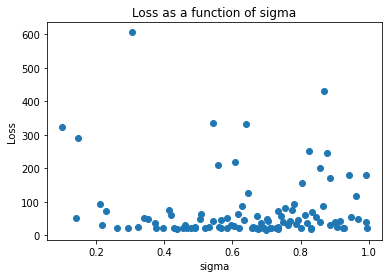

In [ ]:
plot_param_vs_loss(trials, "sigma")

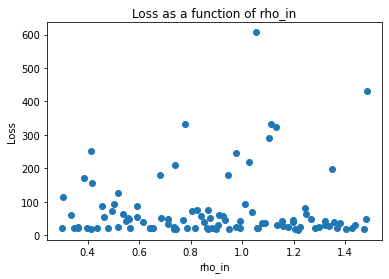

In [ ]:
plot_param_vs_loss(trials, "rho_in")

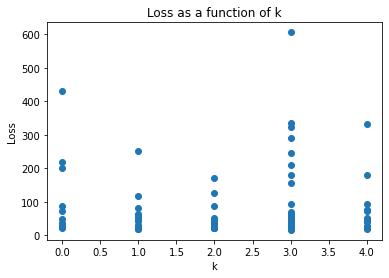

In [ ]:
plot_param_vs_loss(trials, "k")

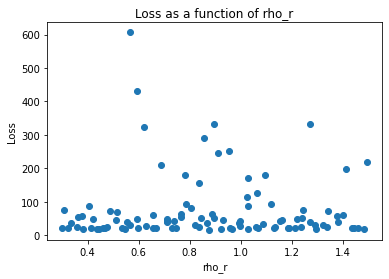

In [ ]:
plot_param_vs_loss(trials, "rho_r")

In [ ]:
results = pd.DataFrame(trials.trials)
results.head()

,state,tid,spec,result,misc,exp_key,owner,version,book_time,refresh_time
0,2,0,None,"{'loss': 18.77383339999626, 'status': 'ok', 'W...","{'tid': 0, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2022-07-14 00:53:59.247,2022-07-14 00:54:00.573
1,2,1,None,"{'loss': 75.82847156031231, 'status': 'ok', 'W...","{'tid': 1, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2022-07-14 00:54:00.575,2022-07-14 00:54:01.881
2,2,2,None,"{'loss': 43.231197054574956, 'status': 'ok', '...","{'tid': 2, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2022-07-14 00:54:01.883,2022-07-14 00:54:03.203
3,2,3,None,"{'loss': 51.53001421506247, 'status': 'ok', 'W...","{'tid': 3, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2022-07-14 00:54:03.204,2022-07-14 00:54:04.637
4,2,4,None,"{'loss': 19.929505262371283, 'status': 'ok', '...","{'tid': 4, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2022-07-14 00:54:04.638,2022-07-14 00:54:05.981


In [ ]:
results['loss'] = [results['result'].iloc[i]['loss'] for i in range(results.shape[0])]

In [ ]:
index_of_best = results['loss'].idxmin()

In [ ]:
best_results = results.iloc[index_of_best]['result']

In [ ]:
best_preds = best_results['preds']['value']

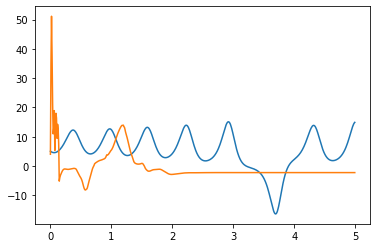

In [ ]:
end = data.lyapunov_to_steps(5, LAMBDA, DEL_T)
x_range = LAMBDA * DEL_T * np.array(range(end))
fig = plt.figure()
plt.plot(x_range, forecast_data[:end, 0])
plt.plot(x_range, best_preds[:end, 0])

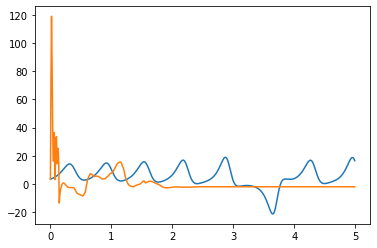

In [ ]:
end = data.lyapunov_to_steps(5, LAMBDA, DEL_T)
x_range = LAMBDA * DEL_T * np.array(range(end))
fig = plt.figure()
plt.plot(x_range, forecast_data[:end, 1])
plt.plot(x_range, best_preds[:end, 1])

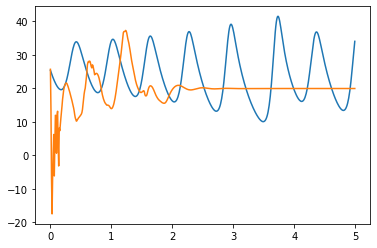

In [ ]:
end = data.lyapunov_to_steps(5, LAMBDA, DEL_T)
x_range = LAMBDA * DEL_T * np.array(range(end))
fig = plt.figure()
plt.plot(x_range, forecast_data[:end, 2])
plt.plot(x_range, best_preds[:end, 2])